<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:10] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


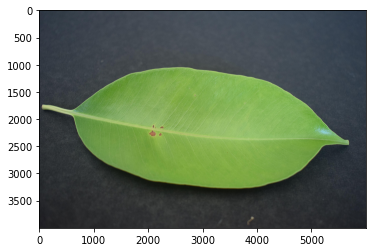

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

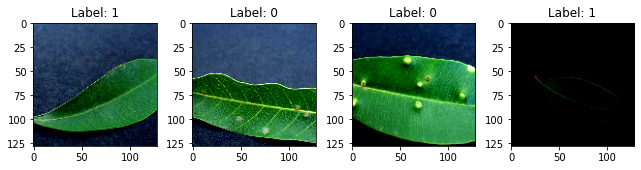

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:15] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.25188838555487 samples/sec                   batch loss = 1.3225845098495483 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.20586348150881 samples/sec                   batch loss = 0.968745231628418 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2637023735635993 samples/sec                   batch loss = 1.097184658050537 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2448180672513633 samples/sec                   batch loss = 0.9680001139640808 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.255400483461769 samples/sec                   batch loss = 1.1372666358947754 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.2595161424243149 samples/sec                   batch loss = 0.5971208214759827 | accuracy = 0.6333333333333333


Epoch[1] Batch[35] Speed: 1.2658820617834847 samples/sec                   batch loss = 0.43008166551589966 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2617259966807641 samples/sec                   batch loss = 0.8263370394706726 | accuracy = 0.6375


Epoch[1] Batch[45] Speed: 1.2545512885175825 samples/sec                   batch loss = 0.7577839493751526 | accuracy = 0.6444444444444445


Epoch[1] Batch[50] Speed: 1.2623669093627412 samples/sec                   batch loss = 0.5249999761581421 | accuracy = 0.655


Epoch[1] Batch[55] Speed: 1.2640011355295846 samples/sec                   batch loss = 0.4905502200126648 | accuracy = 0.6636363636363637


Epoch[1] Batch[60] Speed: 1.2641625714590774 samples/sec                   batch loss = 0.7388860583305359 | accuracy = 0.6666666666666666


Epoch[1] Batch[65] Speed: 1.2624920159338182 samples/sec                   batch loss = 0.594174325466156 | accuracy = 0.6653846153846154


Epoch[1] Batch[70] Speed: 1.2557804866784716 samples/sec                   batch loss = 0.9669261574745178 | accuracy = 0.6678571428571428


Epoch[1] Batch[75] Speed: 1.2579402661142607 samples/sec                   batch loss = 0.8279250264167786 | accuracy = 0.67


Epoch[1] Batch[80] Speed: 1.2579870501809425 samples/sec                   batch loss = 1.3416142463684082 | accuracy = 0.665625


Epoch[1] Batch[85] Speed: 1.256994201957565 samples/sec                   batch loss = 0.31091853976249695 | accuracy = 0.6705882352941176


Epoch[1] Batch[90] Speed: 1.2628849756711282 samples/sec                   batch loss = 0.5118153095245361 | accuracy = 0.6694444444444444


Epoch[1] Batch[95] Speed: 1.2613129905972233 samples/sec                   batch loss = 0.8729621767997742 | accuracy = 0.6710526315789473


Epoch[1] Batch[100] Speed: 1.264069133602785 samples/sec                   batch loss = 0.9284353852272034 | accuracy = 0.6775


Epoch[1] Batch[105] Speed: 1.2668969459016974 samples/sec                   batch loss = 1.0375505685806274 | accuracy = 0.6857142857142857


Epoch[1] Batch[110] Speed: 1.2661520416429382 samples/sec                   batch loss = 0.3833146095275879 | accuracy = 0.6772727272727272


Epoch[1] Batch[115] Speed: 1.2585676129119858 samples/sec                   batch loss = 0.36083003878593445 | accuracy = 0.6847826086956522


Epoch[1] Batch[120] Speed: 1.251732030281423 samples/sec                   batch loss = 0.46166732907295227 | accuracy = 0.6895833333333333


Epoch[1] Batch[125] Speed: 1.2557862204367838 samples/sec                   batch loss = 0.3730904459953308 | accuracy = 0.694


Epoch[1] Batch[130] Speed: 1.2631910549425696 samples/sec                   batch loss = 0.5637874603271484 | accuracy = 0.6865384615384615


Epoch[1] Batch[135] Speed: 1.2626649451033434 samples/sec                   batch loss = 0.9010438919067383 | accuracy = 0.687037037037037


Epoch[1] Batch[140] Speed: 1.2638610673202069 samples/sec                   batch loss = 0.32674476504325867 | accuracy = 0.6875


Epoch[1] Batch[145] Speed: 1.26219102315903 samples/sec                   batch loss = 0.7370003461837769 | accuracy = 0.6862068965517242


Epoch[1] Batch[150] Speed: 1.2655062306729357 samples/sec                   batch loss = 0.18364401161670685 | accuracy = 0.69


Epoch[1] Batch[155] Speed: 1.2671838208608688 samples/sec                   batch loss = 0.5378704071044922 | accuracy = 0.6887096774193548


Epoch[1] Batch[160] Speed: 1.2632949216905782 samples/sec                   batch loss = 0.26341336965560913 | accuracy = 0.6875


Epoch[1] Batch[165] Speed: 1.2653476961307044 samples/sec                   batch loss = 0.9958438873291016 | accuracy = 0.6848484848484848


Epoch[1] Batch[170] Speed: 1.2648063439583639 samples/sec                   batch loss = 0.4980030953884125 | accuracy = 0.6823529411764706


Epoch[1] Batch[175] Speed: 1.2627796555772752 samples/sec                   batch loss = 0.523938000202179 | accuracy = 0.6857142857142857


Epoch[1] Batch[180] Speed: 1.2677555657886166 samples/sec                   batch loss = 0.535452663898468 | accuracy = 0.6861111111111111


Epoch[1] Batch[185] Speed: 1.2662490370419681 samples/sec                   batch loss = 0.5717740654945374 | accuracy = 0.6878378378378378


Epoch[1] Batch[190] Speed: 1.25996354961941 samples/sec                   batch loss = 0.5118587613105774 | accuracy = 0.6855263157894737


Epoch[1] Batch[195] Speed: 1.2579139516059135 samples/sec                   batch loss = 0.3917696177959442 | accuracy = 0.6858974358974359


Epoch[1] Batch[200] Speed: 1.265351036304405 samples/sec                   batch loss = 0.5310442447662354 | accuracy = 0.68625


Epoch[1] Batch[205] Speed: 1.272298281664876 samples/sec                   batch loss = 1.4485102891921997 | accuracy = 0.6865853658536586


Epoch[1] Batch[210] Speed: 1.2614679547504482 samples/sec                   batch loss = 0.40883010625839233 | accuracy = 0.6857142857142857


Epoch[1] Batch[215] Speed: 1.2656882937372962 samples/sec                   batch loss = 0.553682267665863 | accuracy = 0.6883720930232559


Epoch[1] Batch[220] Speed: 1.2607604939845056 samples/sec                   batch loss = 0.44200319051742554 | accuracy = 0.6886363636363636


Epoch[1] Batch[225] Speed: 1.2622154277649211 samples/sec                   batch loss = 0.4123445153236389 | accuracy = 0.69


Epoch[1] Batch[230] Speed: 1.261133131984599 samples/sec                   batch loss = 0.401571661233902 | accuracy = 0.6902173913043478


Epoch[1] Batch[235] Speed: 1.2684079904214014 samples/sec                   batch loss = 0.34236353635787964 | accuracy = 0.6904255319148936


Epoch[1] Batch[240] Speed: 1.2557767268653792 samples/sec                   batch loss = 0.4988906979560852 | accuracy = 0.6864583333333333


Epoch[1] Batch[245] Speed: 1.2561274262986437 samples/sec                   batch loss = 0.9969876408576965 | accuracy = 0.6857142857142857


Epoch[1] Batch[250] Speed: 1.2587803620486921 samples/sec                   batch loss = 0.5234733819961548 | accuracy = 0.689


Epoch[1] Batch[255] Speed: 1.2604286033147862 samples/sec                   batch loss = 0.41037240624427795 | accuracy = 0.6862745098039216


Epoch[1] Batch[260] Speed: 1.2664580815849085 samples/sec                   batch loss = 0.48517245054244995 | accuracy = 0.6855769230769231


Epoch[1] Batch[265] Speed: 1.2540240071086108 samples/sec                   batch loss = 0.802524209022522 | accuracy = 0.6830188679245283


Epoch[1] Batch[270] Speed: 1.260549063969656 samples/sec                   batch loss = 0.4515041410923004 | accuracy = 0.6824074074074075


Epoch[1] Batch[275] Speed: 1.2667234295213807 samples/sec                   batch loss = 2.003765821456909 | accuracy = 0.6827272727272727


Epoch[1] Batch[280] Speed: 1.271425791279391 samples/sec                   batch loss = 0.6991398334503174 | accuracy = 0.6839285714285714


Epoch[1] Batch[285] Speed: 1.2656166842899215 samples/sec                   batch loss = 0.6910447478294373 | accuracy = 0.6833333333333333


Epoch[1] Batch[290] Speed: 1.2639384771157531 samples/sec                   batch loss = 0.36989837884902954 | accuracy = 0.6836206896551724


Epoch[1] Batch[295] Speed: 1.2639048650557667 samples/sec                   batch loss = 0.3541528582572937 | accuracy = 0.6830508474576271


Epoch[1] Batch[300] Speed: 1.2647451311670892 samples/sec                   batch loss = 0.5219311714172363 | accuracy = 0.6833333333333333


Epoch[1] Batch[305] Speed: 1.266588303328026 samples/sec                   batch loss = 0.5060380697250366 | accuracy = 0.6819672131147541


Epoch[1] Batch[310] Speed: 1.268741506604525 samples/sec                   batch loss = 0.6078009605407715 | accuracy = 0.6798387096774193


Epoch[1] Batch[315] Speed: 1.2652933014981582 samples/sec                   batch loss = 0.5242576599121094 | accuracy = 0.6801587301587302


Epoch[1] Batch[320] Speed: 1.2585195583738669 samples/sec                   batch loss = 0.44387754797935486 | accuracy = 0.68046875


Epoch[1] Batch[325] Speed: 1.260401805843976 samples/sec                   batch loss = 0.49659693241119385 | accuracy = 0.6807692307692308


Epoch[1] Batch[330] Speed: 1.2618855231770796 samples/sec                   batch loss = 0.42672282457351685 | accuracy = 0.6803030303030303


Epoch[1] Batch[335] Speed: 1.2557947741735511 samples/sec                   batch loss = 0.5985105633735657 | accuracy = 0.6776119402985075


Epoch[1] Batch[340] Speed: 1.259621202537229 samples/sec                   batch loss = 0.5437926650047302 | accuracy = 0.6779411764705883


Epoch[1] Batch[345] Speed: 1.262993355838621 samples/sec                   batch loss = 0.5116336345672607 | accuracy = 0.6804347826086956


Epoch[1] Batch[350] Speed: 1.2662925225623145 samples/sec                   batch loss = 0.4345874786376953 | accuracy = 0.6807142857142857


Epoch[1] Batch[355] Speed: 1.2606712527748951 samples/sec                   batch loss = 0.4297042489051819 | accuracy = 0.6788732394366197


Epoch[1] Batch[360] Speed: 1.2568060636946836 samples/sec                   batch loss = 0.28594183921813965 | accuracy = 0.68125


Epoch[1] Batch[365] Speed: 1.253191837095674 samples/sec                   batch loss = 0.5590848922729492 | accuracy = 0.6773972602739726


Epoch[1] Batch[370] Speed: 1.256052004689939 samples/sec                   batch loss = 0.2875877022743225 | accuracy = 0.6783783783783783


Epoch[1] Batch[375] Speed: 1.2630325293878824 samples/sec                   batch loss = 0.51542067527771 | accuracy = 0.6806666666666666


Epoch[1] Batch[380] Speed: 1.2649355586322164 samples/sec                   batch loss = 0.4798819124698639 | accuracy = 0.6822368421052631


Epoch[1] Batch[385] Speed: 1.260696545974893 samples/sec                   batch loss = 0.5429695844650269 | accuracy = 0.685064935064935


Epoch[1] Batch[390] Speed: 1.262369094002812 samples/sec                   batch loss = 0.8627477288246155 | accuracy = 0.6833333333333333


Epoch[1] Batch[395] Speed: 1.2658889388219152 samples/sec                   batch loss = 0.73726886510849 | accuracy = 0.6835443037974683


Epoch[1] Batch[400] Speed: 1.265469194364273 samples/sec                   batch loss = 0.6635322570800781 | accuracy = 0.684375


Epoch[1] Batch[405] Speed: 1.262479380659384 samples/sec                   batch loss = 0.40166473388671875 | accuracy = 0.6858024691358025


Epoch[1] Batch[410] Speed: 1.2611780681273954 samples/sec                   batch loss = 0.5242399573326111 | accuracy = 0.6859756097560976


Epoch[1] Batch[415] Speed: 1.2625811350516216 samples/sec                   batch loss = 0.5090851783752441 | accuracy = 0.686144578313253


Epoch[1] Batch[420] Speed: 1.266353980819328 samples/sec                   batch loss = 0.40342170000076294 | accuracy = 0.6857142857142857


Epoch[1] Batch[425] Speed: 1.2682294582091005 samples/sec                   batch loss = 0.8864039182662964 | accuracy = 0.6852941176470588


Epoch[1] Batch[430] Speed: 1.26309329122926 samples/sec                   batch loss = 0.5996396541595459 | accuracy = 0.6854651162790698


Epoch[1] Batch[435] Speed: 1.264200293406433 samples/sec                   batch loss = 0.5580761432647705 | accuracy = 0.6862068965517242


Epoch[1] Batch[440] Speed: 1.259567771936858 samples/sec                   batch loss = 0.639992356300354 | accuracy = 0.6869318181818181


Epoch[1] Batch[445] Speed: 1.2714853397968044 samples/sec                   batch loss = 0.4306803047657013 | accuracy = 0.6865168539325842


Epoch[1] Batch[450] Speed: 1.2669095740869016 samples/sec                   batch loss = 0.6421684622764587 | accuracy = 0.685


Epoch[1] Batch[455] Speed: 1.2657757637353613 samples/sec                   batch loss = 0.4154730439186096 | accuracy = 0.6851648351648352


Epoch[1] Batch[460] Speed: 1.2622512292251673 samples/sec                   batch loss = 0.43526801466941833 | accuracy = 0.6842391304347826


Epoch[1] Batch[465] Speed: 1.261482371956338 samples/sec                   batch loss = 0.4391315281391144 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.2573896830320082 samples/sec                   batch loss = 0.3241196572780609 | accuracy = 0.6840425531914893


Epoch[1] Batch[475] Speed: 1.2633107124537926 samples/sec                   batch loss = 0.3317619860172272 | accuracy = 0.6852631578947368


Epoch[1] Batch[480] Speed: 1.2683989763123096 samples/sec                   batch loss = 0.4278915524482727 | accuracy = 0.6859375


Epoch[1] Batch[485] Speed: 1.2603902539288931 samples/sec                   batch loss = 0.4667927324771881 | accuracy = 0.6865979381443299


Epoch[1] Batch[490] Speed: 1.2575507541159765 samples/sec                   batch loss = 0.35015639662742615 | accuracy = 0.686734693877551


Epoch[1] Batch[495] Speed: 1.2642706946775468 samples/sec                   batch loss = 0.7065050005912781 | accuracy = 0.6863636363636364


Epoch[1] Batch[500] Speed: 1.2698580512709656 samples/sec                   batch loss = 0.31026482582092285 | accuracy = 0.686


Epoch[1] Batch[505] Speed: 1.2692946838822077 samples/sec                   batch loss = 0.38221412897109985 | accuracy = 0.6856435643564357


Epoch[1] Batch[510] Speed: 1.2625554811375421 samples/sec                   batch loss = 0.4798937439918518 | accuracy = 0.6848039215686275


Epoch[1] Batch[515] Speed: 1.2628274656808454 samples/sec                   batch loss = 0.06089363992214203 | accuracy = 0.6864077669902913


Epoch[1] Batch[520] Speed: 1.260967161461696 samples/sec                   batch loss = 1.2205629348754883 | accuracy = 0.6846153846153846


Epoch[1] Batch[525] Speed: 1.267706232338991 samples/sec                   batch loss = 0.4808339476585388 | accuracy = 0.6842857142857143


Epoch[1] Batch[530] Speed: 1.262544554787008 samples/sec                   batch loss = 0.37306344509124756 | accuracy = 0.684433962264151


Epoch[1] Batch[535] Speed: 1.2589201565101924 samples/sec                   batch loss = 0.4017232656478882 | accuracy = 0.6850467289719626


Epoch[1] Batch[540] Speed: 1.2615325501961603 samples/sec                   batch loss = 0.31617990136146545 | accuracy = 0.6842592592592592


Epoch[1] Batch[545] Speed: 1.2602778705281539 samples/sec                   batch loss = 1.0482161045074463 | accuracy = 0.6844036697247706


Epoch[1] Batch[550] Speed: 1.2577030037477224 samples/sec                   batch loss = 0.6642000675201416 | accuracy = 0.6836363636363636


Epoch[1] Batch[555] Speed: 1.2525175637253128 samples/sec                   batch loss = 0.3500133752822876 | accuracy = 0.6855855855855856


Epoch[1] Batch[560] Speed: 1.2516375262016501 samples/sec                   batch loss = 0.4826362133026123 | accuracy = 0.684375


Epoch[1] Batch[565] Speed: 1.2550831447279183 samples/sec                   batch loss = 0.21799571812152863 | accuracy = 0.6853982300884955


Epoch[1] Batch[570] Speed: 1.2546176168868743 samples/sec                   batch loss = 0.5747653245925903 | accuracy = 0.6855263157894737


Epoch[1] Batch[575] Speed: 1.2540652509174584 samples/sec                   batch loss = 0.13599517941474915 | accuracy = 0.6873913043478261


Epoch[1] Batch[580] Speed: 1.2527951563293045 samples/sec                   batch loss = 0.42610007524490356 | accuracy = 0.6887931034482758


Epoch[1] Batch[585] Speed: 1.256421958231641 samples/sec                   batch loss = 0.4786229133605957 | accuracy = 0.688034188034188


Epoch[1] Batch[590] Speed: 1.2682339640430025 samples/sec                   batch loss = 0.8866701722145081 | accuracy = 0.6877118644067797


Epoch[1] Batch[595] Speed: 1.2733583721077617 samples/sec                   batch loss = 0.5592352151870728 | accuracy = 0.6865546218487395


Epoch[1] Batch[600] Speed: 1.2682541927556759 samples/sec                   batch loss = 0.25493982434272766 | accuracy = 0.6866666666666666


Epoch[1] Batch[605] Speed: 1.2707055805425873 samples/sec                   batch loss = 0.7132868766784668 | accuracy = 0.6859504132231405


Epoch[1] Batch[610] Speed: 1.266435711381681 samples/sec                   batch loss = 0.48750582337379456 | accuracy = 0.6848360655737705


Epoch[1] Batch[615] Speed: 1.268398400947994 samples/sec                   batch loss = 0.5797380805015564 | accuracy = 0.6841463414634147


Epoch[1] Batch[620] Speed: 1.2632077942162587 samples/sec                   batch loss = 0.6296482682228088 | accuracy = 0.6842741935483871


Epoch[1] Batch[625] Speed: 1.2695650647313206 samples/sec                   batch loss = 0.9112022519111633 | accuracy = 0.684


Epoch[1] Batch[630] Speed: 1.2736193682999104 samples/sec                   batch loss = 0.6919683814048767 | accuracy = 0.6841269841269841


Epoch[1] Batch[635] Speed: 1.266855523394806 samples/sec                   batch loss = 0.36715036630630493 | accuracy = 0.6850393700787402


Epoch[1] Batch[640] Speed: 1.262464465660912 samples/sec                   batch loss = 0.5970683097839355 | accuracy = 0.68515625


Epoch[1] Batch[645] Speed: 1.2641820036962739 samples/sec                   batch loss = 0.8955376148223877 | accuracy = 0.6848837209302325


Epoch[1] Batch[650] Speed: 1.263767293246732 samples/sec                   batch loss = 0.4360295832157135 | accuracy = 0.6865384615384615


Epoch[1] Batch[655] Speed: 1.2744607938762251 samples/sec                   batch loss = 0.37140771746635437 | accuracy = 0.6874045801526718


Epoch[1] Batch[660] Speed: 1.2664854240176655 samples/sec                   batch loss = 0.4154540002346039 | accuracy = 0.6863636363636364


Epoch[1] Batch[665] Speed: 1.2648916894361077 samples/sec                   batch loss = 0.5921746492385864 | accuracy = 0.6860902255639098


Epoch[1] Batch[670] Speed: 1.2675134376452915 samples/sec                   batch loss = 0.5725905299186707 | accuracy = 0.6865671641791045


Epoch[1] Batch[675] Speed: 1.2720469889336294 samples/sec                   batch loss = 0.844140350818634 | accuracy = 0.6866666666666666


Epoch[1] Batch[680] Speed: 1.2611754135827076 samples/sec                   batch loss = 0.4056793749332428 | accuracy = 0.6878676470588235


Epoch[1] Batch[685] Speed: 1.2638317435764583 samples/sec                   batch loss = 0.1893126666545868 | accuracy = 0.6897810218978102


Epoch[1] Batch[690] Speed: 1.2698015382588161 samples/sec                   batch loss = 0.47524532675743103 | accuracy = 0.6891304347826087


Epoch[1] Batch[695] Speed: 1.2708258959123897 samples/sec                   batch loss = 0.23360717296600342 | accuracy = 0.6902877697841726


Epoch[1] Batch[700] Speed: 1.2570840536104193 samples/sec                   batch loss = 0.41916388273239136 | accuracy = 0.6914285714285714


Epoch[1] Batch[705] Speed: 1.251884929251541 samples/sec                   batch loss = 0.5080306529998779 | accuracy = 0.6918439716312057


Epoch[1] Batch[710] Speed: 1.2612397894417464 samples/sec                   batch loss = 0.27119845151901245 | accuracy = 0.6926056338028169


Epoch[1] Batch[715] Speed: 1.263042893670277 samples/sec                   batch loss = 0.18754199147224426 | accuracy = 0.6923076923076923


Epoch[1] Batch[720] Speed: 1.2597417926742644 samples/sec                   batch loss = 0.47147902846336365 | accuracy = 0.6930555555555555


Epoch[1] Batch[725] Speed: 1.2590734938385593 samples/sec                   batch loss = 0.5606591701507568 | accuracy = 0.6931034482758621


Epoch[1] Batch[730] Speed: 1.2542256588823744 samples/sec                   batch loss = 0.47893062233924866 | accuracy = 0.6938356164383561


Epoch[1] Batch[735] Speed: 1.2681133721237847 samples/sec                   batch loss = 0.3886403441429138 | accuracy = 0.6935374149659864


Epoch[1] Batch[740] Speed: 1.2659360294397832 samples/sec                   batch loss = 0.3500746786594391 | accuracy = 0.6942567567567568


Epoch[1] Batch[745] Speed: 1.2685945345201928 samples/sec                   batch loss = 0.4454108774662018 | accuracy = 0.6949664429530201


Epoch[1] Batch[750] Speed: 1.2709726152373693 samples/sec                   batch loss = 0.49382293224334717 | accuracy = 0.695


Epoch[1] Batch[755] Speed: 1.2691194540942778 samples/sec                   batch loss = 0.5363383293151855 | accuracy = 0.6943708609271523


Epoch[1] Batch[760] Speed: 1.249038014131808 samples/sec                   batch loss = 0.7088015079498291 | accuracy = 0.6944078947368421


Epoch[1] Batch[765] Speed: 1.2571872010593896 samples/sec                   batch loss = 0.9726566076278687 | accuracy = 0.6934640522875817


Epoch[1] Batch[770] Speed: 1.2592658087726996 samples/sec                   batch loss = 1.8661750555038452 | accuracy = 0.6931818181818182


Epoch[1] Batch[775] Speed: 1.2562072777469455 samples/sec                   batch loss = 0.5325618982315063 | accuracy = 0.6935483870967742


Epoch[1] Batch[780] Speed: 1.2514756324189555 samples/sec                   batch loss = 0.4594632089138031 | accuracy = 0.6932692307692307


Epoch[1] Batch[785] Speed: 1.2553290001583264 samples/sec                   batch loss = 0.4302549362182617 | accuracy = 0.6929936305732484


[Epoch 1] training: accuracy=0.6925761421319797
[Epoch 1] time cost: 651.3956201076508
[Epoch 1] validation: validation accuracy=0.76


Epoch[2] Batch[5] Speed: 1.2670272579162885 samples/sec                   batch loss = 0.8008860945701599 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2686225448496191 samples/sec                   batch loss = 0.7426730394363403 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2634381945168227 samples/sec                   batch loss = 0.1513158529996872 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2686091150852672 samples/sec                   batch loss = 0.4141140878200531 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.264015801161882 samples/sec                   batch loss = 0.8779652714729309 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2598638250195806 samples/sec                   batch loss = 0.49636563658714294 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2617057859110556 samples/sec                   batch loss = 0.27980414032936096 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2629594137330107 samples/sec                   batch loss = 0.37234142422676086 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2630414673827899 samples/sec                   batch loss = 0.527816891670227 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2579267786122361 samples/sec                   batch loss = 0.11170991510152817 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2606913356821552 samples/sec                   batch loss = 0.6744435429573059 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2689876555722757 samples/sec                   batch loss = 0.7530304789543152 | accuracy = 0.7166666666666667


Epoch[2] Batch[65] Speed: 1.2666310471378939 samples/sec                   batch loss = 0.4713447093963623 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.2665712831061784 samples/sec                   batch loss = 0.2114153355360031 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2615217364006182 samples/sec                   batch loss = 0.5412781834602356 | accuracy = 0.7266666666666667


Epoch[2] Batch[80] Speed: 1.2619314621405502 samples/sec                   batch loss = 0.49188655614852905 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.260270486305505 samples/sec                   batch loss = 0.13548815250396729 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2590954157194054 samples/sec                   batch loss = 0.6381859183311462 | accuracy = 0.7277777777777777


Epoch[2] Batch[95] Speed: 1.2673180211178678 samples/sec                   batch loss = 1.1901079416275024 | accuracy = 0.7263157894736842


Epoch[2] Batch[100] Speed: 1.2589968677443708 samples/sec                   batch loss = 0.5130255222320557 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2589553933916686 samples/sec                   batch loss = 0.46639546751976013 | accuracy = 0.7214285714285714


Epoch[2] Batch[110] Speed: 1.2615688821126168 samples/sec                   batch loss = 0.24326638877391815 | accuracy = 0.7181818181818181


Epoch[2] Batch[115] Speed: 1.259754089436358 samples/sec                   batch loss = 0.43636244535446167 | accuracy = 0.7217391304347827


Epoch[2] Batch[120] Speed: 1.2528668191415153 samples/sec                   batch loss = 0.17840291559696198 | accuracy = 0.7229166666666667


Epoch[2] Batch[125] Speed: 1.2544297203525816 samples/sec                   batch loss = 0.759807825088501 | accuracy = 0.716


Epoch[2] Batch[130] Speed: 1.2591217796819671 samples/sec                   batch loss = 0.6779435873031616 | accuracy = 0.7153846153846154


Epoch[2] Batch[135] Speed: 1.2597902243879993 samples/sec                   batch loss = 0.18511047959327698 | accuracy = 0.7203703703703703


Epoch[2] Batch[140] Speed: 1.26028004794366 samples/sec                   batch loss = 0.3256376385688782 | accuracy = 0.725


Epoch[2] Batch[145] Speed: 1.2600010213860209 samples/sec                   batch loss = 0.3973716199398041 | accuracy = 0.7310344827586207


Epoch[2] Batch[150] Speed: 1.254363130497768 samples/sec                   batch loss = 0.38672593235969543 | accuracy = 0.7333333333333333


Epoch[2] Batch[155] Speed: 1.2654831304528331 samples/sec                   batch loss = 0.4981798529624939 | accuracy = 0.7338709677419355


Epoch[2] Batch[160] Speed: 1.2621549402569883 samples/sec                   batch loss = 0.4204961657524109 | accuracy = 0.7328125


Epoch[2] Batch[165] Speed: 1.2618020063574389 samples/sec                   batch loss = 0.9091142416000366 | accuracy = 0.7348484848484849


Epoch[2] Batch[170] Speed: 1.2611143621389433 samples/sec                   batch loss = 0.3166539967060089 | accuracy = 0.7352941176470589


Epoch[2] Batch[175] Speed: 1.261632349410134 samples/sec                   batch loss = 0.9132524132728577 | accuracy = 0.7314285714285714


Epoch[2] Batch[180] Speed: 1.262100060219234 samples/sec                   batch loss = 0.24638524651527405 | accuracy = 0.7333333333333333


Epoch[2] Batch[185] Speed: 1.2622204607387684 samples/sec                   batch loss = 0.7750129103660583 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2584613125079183 samples/sec                   batch loss = 0.6586878895759583 | accuracy = 0.7342105263157894


Epoch[2] Batch[195] Speed: 1.2523204803378811 samples/sec                   batch loss = 0.4750271439552307 | accuracy = 0.735897435897436


Epoch[2] Batch[200] Speed: 1.2668714032966775 samples/sec                   batch loss = 0.8641868829727173 | accuracy = 0.7325


Epoch[2] Batch[205] Speed: 1.2649234466152932 samples/sec                   batch loss = 0.44223254919052124 | accuracy = 0.7329268292682927


Epoch[2] Batch[210] Speed: 1.2576490758231116 samples/sec                   batch loss = 0.35432228446006775 | accuracy = 0.7333333333333333


Epoch[2] Batch[215] Speed: 1.2619728480375436 samples/sec                   batch loss = 0.31388697028160095 | accuracy = 0.736046511627907


Epoch[2] Batch[220] Speed: 1.2583741897778158 samples/sec                   batch loss = 0.8661644458770752 | accuracy = 0.7329545454545454


Epoch[2] Batch[225] Speed: 1.2589481191285612 samples/sec                   batch loss = 0.4866602122783661 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.2580240271472347 samples/sec                   batch loss = 0.48652857542037964 | accuracy = 0.7326086956521739


Epoch[2] Batch[235] Speed: 1.2596249854064223 samples/sec                   batch loss = 0.32607078552246094 | accuracy = 0.7351063829787234


Epoch[2] Batch[240] Speed: 1.2603242605728366 samples/sec                   batch loss = 0.8861656785011292 | accuracy = 0.734375


Epoch[2] Batch[245] Speed: 1.2542057814426733 samples/sec                   batch loss = 0.42962318658828735 | accuracy = 0.7326530612244898


Epoch[2] Batch[250] Speed: 1.257911499413902 samples/sec                   batch loss = 0.5610488653182983 | accuracy = 0.732


Epoch[2] Batch[255] Speed: 1.266682305264165 samples/sec                   batch loss = 0.5618155598640442 | accuracy = 0.7323529411764705


Epoch[2] Batch[260] Speed: 1.2603723583474122 samples/sec                   batch loss = 0.2422887235879898 | accuracy = 0.7326923076923076


Epoch[2] Batch[265] Speed: 1.2606931355965953 samples/sec                   batch loss = 0.8902841210365295 | accuracy = 0.7330188679245283


Epoch[2] Batch[270] Speed: 1.252112992768258 samples/sec                   batch loss = 0.4763626456260681 | accuracy = 0.7305555555555555


Epoch[2] Batch[275] Speed: 1.2570770835258036 samples/sec                   batch loss = 0.6336390376091003 | accuracy = 0.7281818181818182


Epoch[2] Batch[280] Speed: 1.2619294688516463 samples/sec                   batch loss = 0.8845252394676208 | accuracy = 0.7285714285714285


Epoch[2] Batch[285] Speed: 1.2587806453844417 samples/sec                   batch loss = 0.20381797850131989 | accuracy = 0.7298245614035088


Epoch[2] Batch[290] Speed: 1.2555829389901716 samples/sec                   batch loss = 0.5430797338485718 | accuracy = 0.728448275862069


Epoch[2] Batch[295] Speed: 1.2528750524700483 samples/sec                   batch loss = 0.3359581232070923 | accuracy = 0.7288135593220338


Epoch[2] Batch[300] Speed: 1.260233377163381 samples/sec                   batch loss = 0.4276942014694214 | accuracy = 0.7308333333333333


Epoch[2] Batch[305] Speed: 1.269816627125271 samples/sec                   batch loss = 0.32977479696273804 | accuracy = 0.7311475409836066


Epoch[2] Batch[310] Speed: 1.2695354757083488 samples/sec                   batch loss = 0.28701794147491455 | accuracy = 0.7298387096774194


Epoch[2] Batch[315] Speed: 1.2642023891361827 samples/sec                   batch loss = 0.4999221861362457 | accuracy = 0.7317460317460317


Epoch[2] Batch[320] Speed: 1.2555789924289793 samples/sec                   batch loss = 0.5187056064605713 | accuracy = 0.73046875


Epoch[2] Batch[325] Speed: 1.2656658552387194 samples/sec                   batch loss = 0.6812230348587036 | accuracy = 0.7307692307692307


Epoch[2] Batch[330] Speed: 1.2662865013121223 samples/sec                   batch loss = 0.4344745874404907 | accuracy = 0.7303030303030303


Epoch[2] Batch[335] Speed: 1.268077429049007 samples/sec                   batch loss = 0.47137805819511414 | accuracy = 0.7328358208955223


Epoch[2] Batch[340] Speed: 1.264396560059646 samples/sec                   batch loss = 0.38220125436782837 | accuracy = 0.7338235294117647


Epoch[2] Batch[345] Speed: 1.2570250929008029 samples/sec                   batch loss = 0.428190678358078 | accuracy = 0.7326086956521739


Epoch[2] Batch[350] Speed: 1.259668017142737 samples/sec                   batch loss = 0.5044047832489014 | accuracy = 0.7335714285714285


Epoch[2] Batch[355] Speed: 1.2645922204271112 samples/sec                   batch loss = 0.20242708921432495 | accuracy = 0.7352112676056338


Epoch[2] Batch[360] Speed: 1.2642304916381917 samples/sec                   batch loss = 0.42454683780670166 | accuracy = 0.7347222222222223


Epoch[2] Batch[365] Speed: 1.260778021608722 samples/sec                   batch loss = 0.34691786766052246 | accuracy = 0.7363013698630136


Epoch[2] Batch[370] Speed: 1.257845576758294 samples/sec                   batch loss = 0.23617388308048248 | accuracy = 0.7385135135135135


Epoch[2] Batch[375] Speed: 1.2643274786814689 samples/sec                   batch loss = 0.23464259505271912 | accuracy = 0.7393333333333333


Epoch[2] Batch[380] Speed: 1.2607378509103693 samples/sec                   batch loss = 0.3734220266342163 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.2651472225711966 samples/sec                   batch loss = 0.7495417594909668 | accuracy = 0.7402597402597403


Epoch[2] Batch[390] Speed: 1.2694692896730908 samples/sec                   batch loss = 0.43847066164016724 | accuracy = 0.7410256410256411


Epoch[2] Batch[395] Speed: 1.2636921888227235 samples/sec                   batch loss = 1.0606428384780884 | accuracy = 0.7411392405063291


Epoch[2] Batch[400] Speed: 1.2643381500703414 samples/sec                   batch loss = 0.30381810665130615 | accuracy = 0.7425


Epoch[2] Batch[405] Speed: 1.2739560179883889 samples/sec                   batch loss = 0.3161156475543976 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.269006372558289 samples/sec                   batch loss = 0.7192972302436829 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.2667217079872959 samples/sec                   batch loss = 0.5670344829559326 | accuracy = 0.7439759036144579


Epoch[2] Batch[420] Speed: 1.2640571334111985 samples/sec                   batch loss = 1.3974214792251587 | accuracy = 0.7404761904761905


Epoch[2] Batch[425] Speed: 1.2652523654643115 samples/sec                   batch loss = 0.46594640612602234 | accuracy = 0.7405882352941177


Epoch[2] Batch[430] Speed: 1.2675073090192444 samples/sec                   batch loss = 0.11043326556682587 | accuracy = 0.7424418604651163


Epoch[2] Batch[435] Speed: 1.2691428792749526 samples/sec                   batch loss = 0.12542667984962463 | accuracy = 0.7425287356321839


Epoch[2] Batch[440] Speed: 1.2633089050572743 samples/sec                   batch loss = 0.5679942965507507 | accuracy = 0.7431818181818182


Epoch[2] Batch[445] Speed: 1.267542166369926 samples/sec                   batch loss = 0.9616216421127319 | accuracy = 0.7426966292134831


Epoch[2] Batch[450] Speed: 1.2726993015226074 samples/sec                   batch loss = 0.2966528534889221 | accuracy = 0.7438888888888889


Epoch[2] Batch[455] Speed: 1.268069090546843 samples/sec                   batch loss = 0.48446956276893616 | accuracy = 0.7434065934065934


Epoch[2] Batch[460] Speed: 1.267693205117404 samples/sec                   batch loss = 0.3251732587814331 | accuracy = 0.7445652173913043


Epoch[2] Batch[465] Speed: 1.2581845059538952 samples/sec                   batch loss = 0.6587660312652588 | accuracy = 0.7446236559139785


Epoch[2] Batch[470] Speed: 1.2647464659622714 samples/sec                   batch loss = 0.25049155950546265 | accuracy = 0.7468085106382979


Epoch[2] Batch[475] Speed: 1.2663349596637843 samples/sec                   batch loss = 0.3730062246322632 | accuracy = 0.7468421052631579


Epoch[2] Batch[480] Speed: 1.2713647068487612 samples/sec                   batch loss = 0.4485723376274109 | accuracy = 0.746875


Epoch[2] Batch[485] Speed: 1.261610908323344 samples/sec                   batch loss = 0.2476753443479538 | accuracy = 0.7479381443298969


Epoch[2] Batch[490] Speed: 1.2643650199008507 samples/sec                   batch loss = 0.4728304147720337 | accuracy = 0.7474489795918368


Epoch[2] Batch[495] Speed: 1.265775668237505 samples/sec                   batch loss = 0.1869795173406601 | accuracy = 0.747979797979798


Epoch[2] Batch[500] Speed: 1.2694448919177346 samples/sec                   batch loss = 0.46411025524139404 | accuracy = 0.749


Epoch[2] Batch[505] Speed: 1.273766346565214 samples/sec                   batch loss = 0.31754833459854126 | accuracy = 0.7495049504950495


Epoch[2] Batch[510] Speed: 1.2647304486060327 samples/sec                   batch loss = 0.38255175948143005 | accuracy = 0.7514705882352941


Epoch[2] Batch[515] Speed: 1.26602802385659 samples/sec                   batch loss = 0.3413824141025543 | accuracy = 0.7524271844660194


Epoch[2] Batch[520] Speed: 1.2701494422073925 samples/sec                   batch loss = 0.6521962881088257 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.2692604982727098 samples/sec                   batch loss = 0.2886509597301483 | accuracy = 0.75


Epoch[2] Batch[530] Speed: 1.2710084337600402 samples/sec                   batch loss = 0.5016617774963379 | accuracy = 0.75


Epoch[2] Batch[535] Speed: 1.2648425786202213 samples/sec                   batch loss = 0.9273184537887573 | accuracy = 0.7504672897196262


Epoch[2] Batch[540] Speed: 1.2656102875735522 samples/sec                   batch loss = 0.6956238150596619 | accuracy = 0.750462962962963


Epoch[2] Batch[545] Speed: 1.264657422230638 samples/sec                   batch loss = 0.26136425137519836 | accuracy = 0.7509174311926605


Epoch[2] Batch[550] Speed: 1.2656052275302896 samples/sec                   batch loss = 0.9105449914932251 | accuracy = 0.7513636363636363


Epoch[2] Batch[555] Speed: 1.2647525679189846 samples/sec                   batch loss = 0.38088783621788025 | accuracy = 0.7518018018018018


Epoch[2] Batch[560] Speed: 1.2643392934441193 samples/sec                   batch loss = 0.12269512563943863 | accuracy = 0.7526785714285714


Epoch[2] Batch[565] Speed: 1.267738705770075 samples/sec                   batch loss = 0.857781708240509 | accuracy = 0.7522123893805309


Epoch[2] Batch[570] Speed: 1.2668942672281092 samples/sec                   batch loss = 0.8925650715827942 | accuracy = 0.7530701754385964


Epoch[2] Batch[575] Speed: 1.2707641953447775 samples/sec                   batch loss = 0.968532919883728 | accuracy = 0.7526086956521739


Epoch[2] Batch[580] Speed: 1.272270301747205 samples/sec                   batch loss = 0.6650153398513794 | accuracy = 0.7530172413793104


Epoch[2] Batch[585] Speed: 1.265422138470261 samples/sec                   batch loss = 0.5231201648712158 | accuracy = 0.7521367521367521


Epoch[2] Batch[590] Speed: 1.2615224004002652 samples/sec                   batch loss = 1.2469764947891235 | accuracy = 0.7521186440677966


Epoch[2] Batch[595] Speed: 1.2768065225046334 samples/sec                   batch loss = 0.8197606801986694 | accuracy = 0.7508403361344538


Epoch[2] Batch[600] Speed: 1.271061780140887 samples/sec                   batch loss = 0.33736932277679443 | accuracy = 0.7504166666666666


Epoch[2] Batch[605] Speed: 1.2737611243877738 samples/sec                   batch loss = 0.21486911177635193 | accuracy = 0.7516528925619834


Epoch[2] Batch[610] Speed: 1.2662643283130477 samples/sec                   batch loss = 0.336256742477417 | accuracy = 0.7516393442622951


Epoch[2] Batch[615] Speed: 1.2627768992403265 samples/sec                   batch loss = 0.684377133846283 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.2646213888238969 samples/sec                   batch loss = 0.447723925113678 | accuracy = 0.75


Epoch[2] Batch[625] Speed: 1.2695385498283493 samples/sec                   batch loss = 0.46046534180641174 | accuracy = 0.7496


Epoch[2] Batch[630] Speed: 1.266828547606603 samples/sec                   batch loss = 0.10167781263589859 | accuracy = 0.7507936507936508


Epoch[2] Batch[635] Speed: 1.2606182066631346 samples/sec                   batch loss = 0.16416668891906738 | accuracy = 0.7511811023622047


Epoch[2] Batch[640] Speed: 1.2576348403768074 samples/sec                   batch loss = 1.3383703231811523 | accuracy = 0.751171875


Epoch[2] Batch[645] Speed: 1.2636333680174647 samples/sec                   batch loss = 0.44154876470565796 | accuracy = 0.7503875968992249


Epoch[2] Batch[650] Speed: 1.264481183123716 samples/sec                   batch loss = 0.18330547213554382 | accuracy = 0.7507692307692307


Epoch[2] Batch[655] Speed: 1.2646369267871558 samples/sec                   batch loss = 0.2652749717235565 | accuracy = 0.751145038167939


Epoch[2] Batch[660] Speed: 1.2610991949950558 samples/sec                   batch loss = 0.35247766971588135 | accuracy = 0.7515151515151515


Epoch[2] Batch[665] Speed: 1.2550344170635805 samples/sec                   batch loss = 0.721756100654602 | accuracy = 0.7507518796992482


Epoch[2] Batch[670] Speed: 1.2674342488703572 samples/sec                   batch loss = 0.9080498218536377 | accuracy = 0.7496268656716418


Epoch[2] Batch[675] Speed: 1.265168593214283 samples/sec                   batch loss = 0.3554013669490814 | accuracy = 0.7507407407407407


Epoch[2] Batch[680] Speed: 1.2623454433016157 samples/sec                   batch loss = 0.3601183593273163 | accuracy = 0.7507352941176471


Epoch[2] Batch[685] Speed: 1.2613184905090709 samples/sec                   batch loss = 0.6652336716651917 | accuracy = 0.7507299270072992


Epoch[2] Batch[690] Speed: 1.2584110007272693 samples/sec                   batch loss = 0.39375099539756775 | accuracy = 0.7507246376811594


Epoch[2] Batch[695] Speed: 1.262977573007964 samples/sec                   batch loss = 0.34746116399765015 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.2615935472693323 samples/sec                   batch loss = 0.18215908110141754 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.2668856572825806 samples/sec                   batch loss = 0.41673943400382996 | accuracy = 0.75177304964539


Epoch[2] Batch[710] Speed: 1.2554918925018832 samples/sec                   batch loss = 0.7037103772163391 | accuracy = 0.7517605633802817


Epoch[2] Batch[715] Speed: 1.2630153193497298 samples/sec                   batch loss = 0.4409480690956116 | accuracy = 0.7517482517482518


Epoch[2] Batch[720] Speed: 1.2655179720171532 samples/sec                   batch loss = 0.6377487778663635 | accuracy = 0.7510416666666667


Epoch[2] Batch[725] Speed: 1.2662406270002922 samples/sec                   batch loss = 0.5516601204872131 | accuracy = 0.7510344827586207


Epoch[2] Batch[730] Speed: 1.2645605751916564 samples/sec                   batch loss = 0.712871253490448 | accuracy = 0.75


Epoch[2] Batch[735] Speed: 1.2644416337729165 samples/sec                   batch loss = 1.1405730247497559 | accuracy = 0.75


Epoch[2] Batch[740] Speed: 1.2673317107586972 samples/sec                   batch loss = 0.4903532862663269 | accuracy = 0.7493243243243243


Epoch[2] Batch[745] Speed: 1.26184490225209 samples/sec                   batch loss = 0.33858031034469604 | accuracy = 0.75


Epoch[2] Batch[750] Speed: 1.261568123200012 samples/sec                   batch loss = 0.38003644347190857 | accuracy = 0.7503333333333333


Epoch[2] Batch[755] Speed: 1.2615465894353732 samples/sec                   batch loss = 0.44234389066696167 | accuracy = 0.7506622516556292


Epoch[2] Batch[760] Speed: 1.2551684037698407 samples/sec                   batch loss = 0.34324294328689575 | accuracy = 0.7506578947368421


Epoch[2] Batch[765] Speed: 1.2662393846172424 samples/sec                   batch loss = 0.7221325039863586 | accuracy = 0.7506535947712418


Epoch[2] Batch[770] Speed: 1.260991897872471 samples/sec                   batch loss = 0.46330153942108154 | accuracy = 0.7506493506493507


Epoch[2] Batch[775] Speed: 1.2635479067678286 samples/sec                   batch loss = 0.49063557386398315 | accuracy = 0.7509677419354839


Epoch[2] Batch[780] Speed: 1.2609097312388637 samples/sec                   batch loss = 0.5055078864097595 | accuracy = 0.7516025641025641


Epoch[2] Batch[785] Speed: 1.2559695403047466 samples/sec                   batch loss = 0.726256787776947 | accuracy = 0.75


[Epoch 2] training: accuracy=0.7506345177664975
[Epoch 2] time cost: 641.7287271022797
[Epoch 2] validation: validation accuracy=0.7711111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)